[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andandandand/practical-computer-vision/blob/main/notebooks/Predicting_Car_Prices_Based_on_Their_Images.ipynb)

# Predicting car prices based on their images

#### Author: Antonio Rueda-Toicen

**antonio.rueda.toicen 'at' hpi 'dot' de**


[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

When running this notebook on Google Colab, select a Runtime with the T4 GPU enabled.

## Fine-tuning a Pre-trained EfficientNet to predict car prices

[EfficientNet is a convolutional neural network](https://arxiv.org/abs/1905.11946) that performs very well on both classification and regression tasks.

Please don't worry if much of the code doesn't make sense to you at this point right now, we will delve into [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) and the fine-tuning of pre-trained networks later into the course.

This example is just to:

1. Motivate you :)
2. Illustrate the importance of the evaluation of the loss function on the validation set to decide when to checkpoint or stop training a model

In [1]:
!pip install fiftyone==1.4.1 > /dev/null
!pip install datasets==3.3.2 > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82 

In [2]:
import fiftyone as fo
import datasets
# Check installation success
fo.__version__, datasets.__version__

('1.4.1', '3.3.2')

In [3]:
from datasets import load_dataset

# Load the dataset from Hugging Face
dataset_name = "andandandand/stanford_cars_sample_with_prices"
hf_dataset = load_dataset(dataset_name)
hf_dataset


README.md:   0%|          | 0.00/9.30k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/356M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/126M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2913 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/971 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/971 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'price'],
        num_rows: 2913
    })
    validation: Dataset({
        features: ['image', 'label', 'price'],
        num_rows: 971
    })
    test: Dataset({
        features: ['image', 'label', 'price'],
        num_rows: 971
    })
})

In [4]:
models_list = hf_dataset["train"].features["label"].names
len(models_list)

196

In [5]:
import fiftyone as fo

# Check if the dataset exists and skip this cell if it does.
if not fo.dataset_exists("stanford_cars_with_prices"):
  # Create an unique FiftyOne dataset
  fo_dataset = fo.Dataset("stanford_cars_with_prices")

  # Process all splits
  for split in hf_dataset:
      for idx, sample_data in enumerate(hf_dataset[split]):
          # Extract image data and metadata
          image_data = sample_data["image"].convert("RGB")

          # Save the image to a temporary file (FiftyOne works with file paths)
          temp_path = f"/tmp/image_{split}_{idx}.jpg"  # Include split in filename
          image_data.save(temp_path)

          # Create a FiftyOne sample
          sample = fo.Sample(filepath=temp_path)

          # Add metadata as fields
          sample["split"] = split  # Add the split field
          if "label" in sample_data:
              sample["model"] = models_list[sample_data["label"]]
          if "price" in sample_data:
              sample["price"] = sample_data["price"]
          if "year" in sample_data:
              sample["year"] = sample_data["year"]

          # Add to fo_dataset
          fo_dataset.add_sample(sample)

      print(f"Added {len(hf_dataset[split])} samples from split '{split}' to the FiftyOne dataset")

  # Visualize the dataset
  session = fo.launch_app(fo_dataset, auto=False)


Added 2913 samples from split 'train' to the FiftyOne dataset
Added 971 samples from split 'validation' to the FiftyOne dataset
Added 971 samples from split 'test' to the FiftyOne dataset
Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.4.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.4.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



In [6]:
print("Click on the url to view the dataset in a browser window")
print(session.url)

Click on the url to view the dataset in a browser window
https://5151-gpu-t4-hm-18iw4w9ao2sj6-c.us-east1-0.prod.colab.dev?polling=true


## Fine-tuning an EfficientNet to predict car prices

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import timm
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from datasets import DatasetDict

# Configuration parameters
MODEL_NAME = "efficientnet_b0"  # Can be changed to other variants like b1-b7
BATCH_SIZE = 32
LEARNING_RATE = 0.003
NUM_EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Custom dataset class to handle the HuggingFace dataset
class HFImageDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image']
        price = item['price']

        # Convert image to RGB
        image = image.convert("RGB")

        # Convert price to tensor (log scaled for numerical stability)
        # Q: Can you identify the effect of using the log-scale during training?
        # Q: What would happen to our training if we remove the call to .log()?
        price_tensor = torch.tensor(price, dtype=torch.float32).log()

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, price_tensor

# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])



Using device: cuda


In [8]:
# Define the EfficientNet model for regression
class EfficientNetRegressor(nn.Module):
    def __init__(self, model_name="efficientnet_b0", pretrained=True):
        super(EfficientNetRegressor, self).__init__()
        # Load pre-trained EfficientNet
        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        # Get the number of features in the last layer
        if 'efficientnet' in model_name:
            num_features = self.backbone.classifier.in_features
            # Replace the classifier with a single output regression head
            self.backbone.classifier = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(num_features, 1)
            )
        else:
            # For other models, may need different handling
            raise ValueError(f"Model {model_name} not supported yet")

    def forward(self, x):
        # Forward pass through the model
        x = self.backbone(x)

        return x.squeeze(-1)


In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=DEVICE):
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
    }

    # Initialize best validation loss for model checkpointing
    best_val_loss = float('inf')
    best_model_path = 'best_efficientnet_price_predictor.pth'

    # Train the model
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0

        for images, prices in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            prices = prices.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, prices)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1

        avg_train_loss = train_loss / train_batches
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0

        with torch.no_grad():
            for images, prices in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images = images.to(device)
                prices = prices.to(device)

                outputs = model(images)
                loss = criterion(outputs, prices)

                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}")

        # Check if this is the best model so far based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            # Save the model checkpoint
            torch.save(model.state_dict(), best_model_path)
            print(f"Checkpoint saved: validation loss improved to {best_val_loss:.4f}")

    # Load the best model before returning
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model with validation loss: {best_val_loss:.4f}")

    return history, best_val_loss

def evaluate_model(model, test_loader, criterion, device=DEVICE):
    model.eval()
    test_loss = 0.0
    test_batches = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, prices in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            prices = prices.to(device)

            outputs = model(images)
            loss = criterion(outputs, prices)

            test_loss += loss.item()
            test_batches += 1

            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(prices.cpu().numpy())

    avg_test_loss = test_loss / test_batches

    # Undo the log scaling we applied in the data loader
    all_preds_exp = np.exp(all_preds)
    all_targets_exp = np.exp(all_targets)
    mae_exp = np.mean(np.abs(all_preds_exp - all_targets_exp))
    mae = np.mean(np.abs(np.array(all_preds) - np.array(all_targets)))

    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Mean Absolute Error (Log): {mae:.4f}")
    print(f"Mean Absolute Error: {mae_exp:.4f}")

    return all_preds_exp, all_targets_exp, mae_exp

def plot_results(history, all_preds, all_targets):
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(all_targets, all_preds, alpha=0.3)
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r')
    plt.title('Predicted vs Actual Price')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')

    plt.tight_layout()
    plt.savefig('price_prediction_results.png')
    plt.show()


# Create dataloaders
def create_dataloaders(hf_dataset, batch_size=BATCH_SIZE):
    # Create custom datasets
    train_dataset = HFImageDataset(hf_dataset['train'], transform=transform)
    val_dataset = HFImageDataset(hf_dataset['validation'], transform=transform)
    test_dataset = HFImageDataset(hf_dataset['test'], transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader



## Create train and validation loaders

In [10]:
# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(hf_dataset)

# Initialize the model
model = EfficientNetRegressor(model_name=MODEL_NAME, pretrained=True)
# Send the model to the GPU (if available)
model = model.to(DEVICE)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# L1Loss: Mean Absolute Error in PyTorch

## Mathematical Definition

[L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) in PyTorch implements the [Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error) loss function:

$$\text{L1Loss}(x, y) = \frac{1}{n}\sum_{i=1}^{n}|x_i - y_i|$$

Where $x_i$ is the predicted value, $y_i$ is the target value, and $n$ is the number of elements.

In this notebook we use to adjust the weights of the model during training.

## PyTorch Implementation

```python
criterion = nn.L1Loss()  # Mean Absolute Error loss

# Forward pass
output = model(input)
# We use the loss value to adjust the weights
loss = criterion(output, target)

# Backward pass to compute gradients of loss wrt weights
loss.backward()
# We update the weights by calling optimizer.step()
optimizer.step()
```



In [11]:
# Define loss function and optimizer
criterion = nn.L1Loss()  # Mean Absolute Error loss
# The LEARNING_RATE defines how big is the step that we take to adjust the weights
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [12]:
# Train the model
history, best_val_loss = train_model(
     model,
     train_loader,
     val_loader,
     criterion,
     optimizer,
     num_epochs=NUM_EPOCHS
 )



Epoch 1/10 - Validation: 100%|██████████| 31/31 [00:04<00:00,  6.63it/s]


Epoch 1/10: Train Loss: 1.4327, Val Loss: 0.8404
Checkpoint saved: validation loss improved to 0.8404


Epoch 2/10 - Validation: 100%|██████████| 31/31 [00:04<00:00,  6.27it/s]


Epoch 2/10: Train Loss: 0.7031, Val Loss: 0.6764
Checkpoint saved: validation loss improved to 0.6764


Epoch 3/10 - Validation: 100%|██████████| 31/31 [00:04<00:00,  6.95it/s]


Epoch 3/10: Train Loss: 0.6287, Val Loss: 0.6153
Checkpoint saved: validation loss improved to 0.6153


Epoch 4/10 - Validation: 100%|██████████| 31/31 [00:04<00:00,  6.61it/s]


Epoch 4/10: Train Loss: 0.6010, Val Loss: 0.7219


Epoch 5/10 - Validation: 100%|██████████| 31/31 [00:04<00:00,  6.82it/s]


Epoch 5/10: Train Loss: 0.5558, Val Loss: 0.7074


Epoch 6/10 - Validation: 100%|██████████| 31/31 [00:04<00:00,  6.59it/s]


Epoch 6/10: Train Loss: 0.5588, Val Loss: 0.5983
Checkpoint saved: validation loss improved to 0.5983


Epoch 7/10 - Validation: 100%|██████████| 31/31 [00:04<00:00,  6.71it/s]


Epoch 7/10: Train Loss: 0.5355, Val Loss: 0.5428
Checkpoint saved: validation loss improved to 0.5428


Epoch 8/10 - Validation: 100%|██████████| 31/31 [00:04<00:00,  6.74it/s]


Epoch 8/10: Train Loss: 0.5319, Val Loss: 0.5481


Epoch 9/10 - Validation: 100%|██████████| 31/31 [00:04<00:00,  6.68it/s]


Epoch 9/10: Train Loss: 0.5017, Val Loss: 0.5762


Epoch 10/10 - Validation: 100%|██████████| 31/31 [00:04<00:00,  6.75it/s]

Epoch 10/10: Train Loss: 0.4639, Val Loss: 0.5919
Loaded best model with validation loss: 0.5428


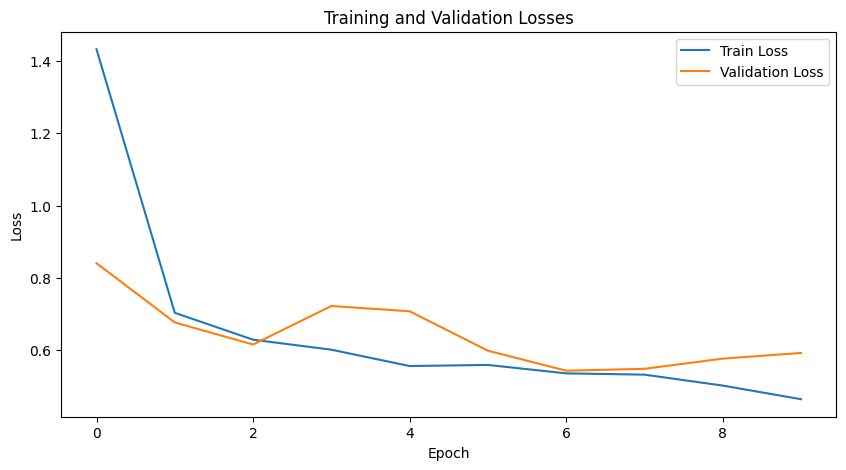

In [13]:
import matplotlib.pyplot as plt

def plot_losses(history):
  """Plots the training and validation losses."""
  plt.figure(figsize=(10, 5))
  plt.plot(history['train_loss'], label='Train Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Losses')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Call the function to plot the losses
plot_losses(history)

In [14]:
# Evaluate the model (run this in a notebook cell)
all_preds, all_targets, mae = evaluate_model(model, test_loader, criterion)


Testing: 100%|██████████| 31/31 [00:04<00:00,  7.08it/s]

Test Loss: 0.5466
Mean Absolute Error (Log): 0.5433
Mean Absolute Error: 37182.7383


## Use the best model for inference on the test set

The model that achieved the best performance on the validation set is the one that we use for inference on the test set. This is how we obtain a benchmark for how good is our model at predicting car prices.

In [15]:
# Loading the best model for inference (run this in a notebook cell when needed)
model = EfficientNetRegressor(model_name=MODEL_NAME)
model.load_state_dict(torch.load('best_efficientnet_price_predictor.pth'))
model = model.to(DEVICE)
model.eval()

EfficientNetRegressor(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (c

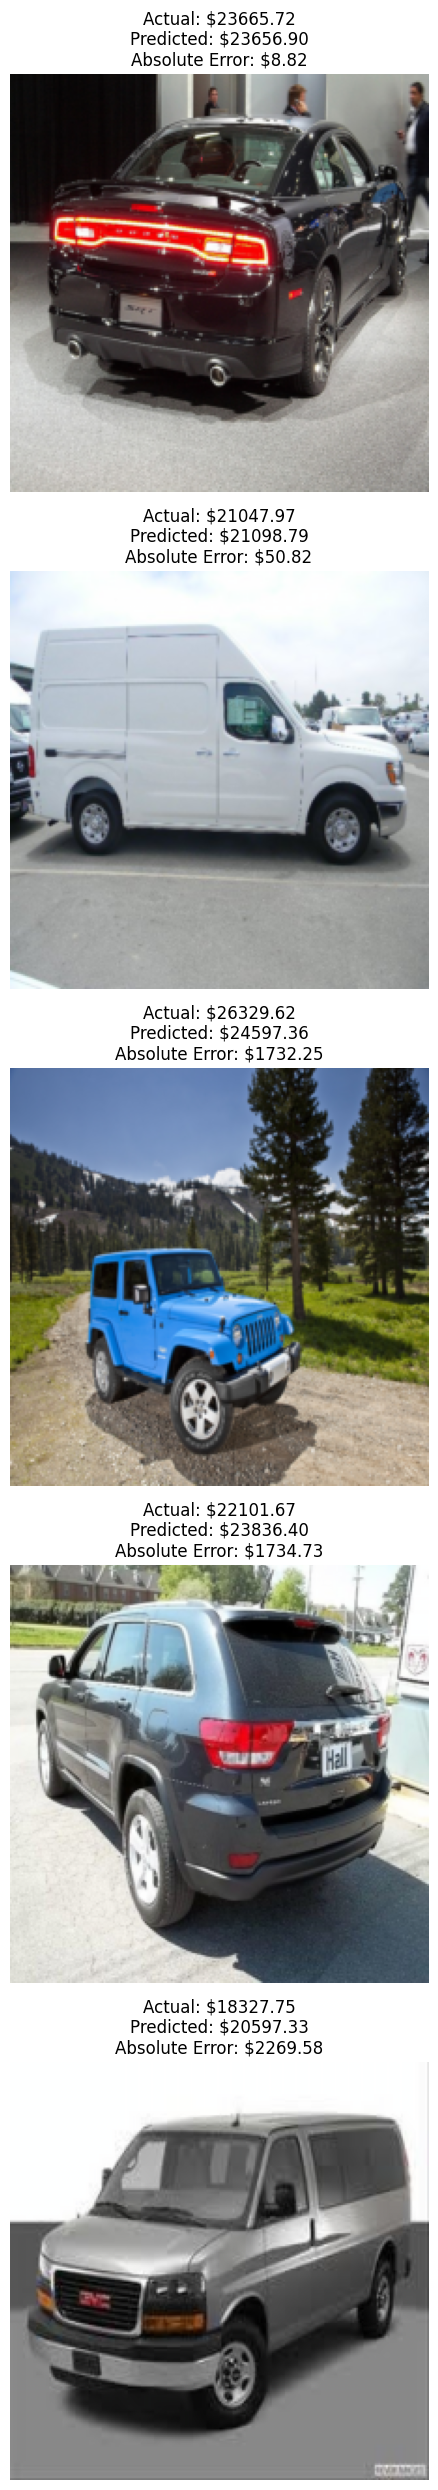

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(model, test_loader, device=DEVICE, num_samples=5):
    """Displays predicted prices, images, and absolute errors from the test set,
    sorted by lowest absolute error.
    """
    model.eval()  # Set the model to evaluation mode

    # Get a batch of data from the test loader
    images, targets = next(iter(test_loader))
    images = images.to(device)
    targets = targets.to(device)

    # Get predictions from the model
    with torch.no_grad():
        predictions = model(images)

    # Move data back to CPU for plotting and sorting
    # Undo the log scaling we used during training
    images = images.cpu()
    targets = targets.exp().cpu().numpy()
    predictions = predictions.exp().cpu().numpy()

    # Calculate absolute errors and sort indices
    absolute_errors = np.abs(targets - predictions)
    sorted_indices = np.argsort(absolute_errors)

    # Display images and predictions, sorted by lowest error
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, num_samples * 5))
    for i in range(num_samples):
        ax = axes[i]
        index = sorted_indices[i]  # Get the index of the sample with the i-th lowest error

        # Un-normalize the image for display
        image = images[index].numpy().transpose(1, 2, 0)
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        ax.imshow(image)
        absolute_error = absolute_errors[index]
        ax.set_title(f"Actual: ${targets[index]:.2f}\nPredicted: ${predictions[index]:.2f}\nAbsolute Error: ${absolute_error:.2f}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to show predictions
show_predictions(model, test_loader)

## Inspecting predictions on the test set with FiftyOne

Select subsets of data with the slider on `predicted_price`. Compare these with `price`. Are there data quality or model issues that you can identify?

![](https://github.com/andandandand/practical-computer-vision/blob/main/images/prices-cars.png?raw=true)

In [18]:
import fiftyone.utils.torch as foutils # FiftyOne utility for PyTorch
from fiftyone import ViewField as F # For filtering/expressions
from torchvision import transforms
from PIL import Image

# --- Ensure the best model is loaded and in eval mode ---
# (You should already have this from the previous steps)
model = EfficientNetRegressor(model_name=MODEL_NAME)
# Use the correct path where your best model was saved
model.load_state_dict(torch.load('best_efficientnet_price_predictor.pth'))
model = model.to(DEVICE)
model.eval() # Set to evaluation mode

# --- Define the *exact same* transformations used during training ---
# (Ensure this matches the transform object used earlier)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True), # Added antialias for newer torchvision
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# --- Get the test split view from the FiftyOne dataset ---
# Make sure fo_dataset is your loaded FiftyOne dataset variable
test_view = fo_dataset.match(F("split") == "test")
print(f"Found {len(test_view)} samples in the test split.")

# --- Add predictions to the test samples ---
# Use a new field name for predictions
prediction_field = "predicted_price"
abs_error_field = "absolute_error" # Optional: store error too

# Use FiftyOne's ProgressBar to monitor how are we adding samples
with fo.ProgressBar(total=len(test_view)) as pb:
    for sample in pb(test_view):
        try:
            # Load image using PIL
            image = Image.open(sample.filepath).convert("RGB")

            # Apply transformations
            image_tensor = transform(image).unsqueeze(0) # Add batch dimension
            image_tensor = image_tensor.to(DEVICE)

            # Get prediction
            with torch.no_grad(): # Disable gradient calculations
                prediction = model(image_tensor)

            # Undo the log scaling we used during training
            # Store prediction (move to CPU, get scalar value)
            predicted_price = prediction.exp().item() # .item() gets the Python number
            sample[prediction_field] = predicted_price

            # Optional: Calculate and store absolute error
            if sample.price is not None: # Check if ground truth exists
                 sample[abs_error_field] = abs(sample.price - predicted_price)
            else:
                 sample[abs_error_field] = None # Or some indicator value

            # Save the changes to the sample in the database
            sample.save()

        except Exception as e:
            print(f"Error processing sample {sample.filepath}: {e}")
            # Optionally add an error tag or skip
            sample[prediction_field] = None
            sample[abs_error_field] = None
            sample.save()


print(f"Predictions added to field '{prediction_field}' for test samples.")
if abs_error_field:
    print(f"Absolute error added to field '{abs_error_field}'.")



# If you closed the previous session or want a new one:
session = fo.launch_app(fo_dataset, auto=False)
print("Launched new session. Copy URL into browser:")
print(session.url)

Found 971 samples in the test split.
 100% |█████████████████| 971/971 [18.0s elapsed, 0s remaining, 55.2 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 971/971 [18.0s elapsed, 0s remaining, 55.2 samples/s]      


Predictions added to field 'predicted_price' for test samples.
Absolute error added to field 'absolute_error'.
Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.


Launched new session. Copy URL into browser:
https://5151-gpu-t4-hm-18iw4w9ao2sj6-c.us-east1-0.prod.colab.dev?polling=true


## Suggested exercises

1. Re-structure this notebook so that we save the predicted prices on samples from the validation set too.
2. Train the model for more epochs and with different learning rates (consider using a scheduler).
3. Replace the EfficientNet model with a model trained from scratch.
4. Try replacing EfficientNet with a different model from [timm's leaderboard](https://huggingface.co/spaces/timm/leaderboard).
5. Train the model to perform classification of the cars' models instead of regression of the price.
6. Which data quality issues could you identify on the train, validation, and test sets?